In [6]:
from matplotlib import *
from pylab import *
from numpy import *
from pyspecdata import *

Provide file names, start making figlist

In [7]:
filename1 = 'VectorH_240606_fixed.fld' #90 deg phase
filename2 = 'VectorH_240523.fld' #0 deg phase
fl = figlist_var()

Define how axes are constructed based on which dimension fields are plotted on, pop() to remove irrelevant dimension

In [8]:
def construct_axes_from_positions(positions):
    #{{{ construct the axes
    list_of_axes = [unique(positions[:,j]) for j in range(0,3)]
    list_of_indeces = [0,1,2]
    for j in range(0,len(list_of_axes)):
        if len(list_of_axes[j]) == 1:
            list_of_axes.pop(j)
            list_of_indeces.pop(j)
            break
    [u_axis,v_axis] = list_of_axes
    [u_index,v_index] = list_of_indeces
    return u_index,v_index,u_axis,v_axis
    #}}}

Defines how a vector file is opened, read, enumerated to individual values, and NAN separated from #s

In [9]:
def load_hfss_vectors(filename,show_valid = False):
    fp = open(filename,'r')
    data = fp.readlines()
    fp.close()
    header = data[0:2]
    print("the second line tells me what's in the file -- x,y,z, followed by the 3 positions of vector data and the final part tells me what it is")
    print('header is',r'\begin{verbatim}', header, r'\end{verbatim}')
    data = data[2:]
    positions = empty((len(data),3),dtype = 'double')
    vec_vals = empty((len(data),3),dtype = 'double')
    for j,line in enumerate(data):
        vals = [double(x) for x in line.strip().split(" ") if len(x)>0]
        positions[j,:] = vals[0:3]
        vec_vals[j,:] = vals[3:]
    u_index,v_index,u_axis,v_axis = construct_axes_from_positions(positions)
    #{{{ show the datapoints and which are valid
    if show_valid:
        fl.next('show valid values')
        thismask = isnan(vec_vals[:,u_index])
        print("invalid/valid",sum(thismask), sum(~thismask))
        fl.plot(positions[:,u_index][thismask],positions[:,v_index][thismask],'r.')
        fl.plot(positions[:,u_index][~thismask],positions[:,v_index][~thismask],'b.') # '~' = 'not'
        xlabel('u')
        ylabel('v')
        gca().set_aspect('equal', 'datalim')
    #}}}
    data = empty((len(u_axis),len(v_axis),3),dtype = 'double')
    for j in range(0,positions.shape[0]):
        u_i = where(u_axis == positions[j,u_index])[0][0]
        v_i = where(v_axis == positions[j,v_index])[0][0]
        data[u_i,v_i,:] = vec_vals[j,:]
    return u_index,u_axis,v_index,v_axis,data

the second line tells me what's in the file -- x,y,z, followed by the 3 positions of vector data and the final part tells me what it is
header is \begin{verbatim} ['Grid Output Min: [-25mm 0mm -20mm] Max: m 0mm 50mm] Grid Size: m 0mm 1mm]\n', 'X, Y, Z, Vector data "Vector_H"\n'] \end{verbatim}
the second line tells me what's in the file -- x,y,z, followed by the 3 positions of vector data and the final part tells me what it is
header is \begin{verbatim} ['Grid Output Min: [-25mm 0mm -20mm] Max: m 0mm 50mm] Grid Size: m 0mm 1mm]\n', 'X, Y, Z, Vector data "Vector_H"\n'] \end{verbatim}


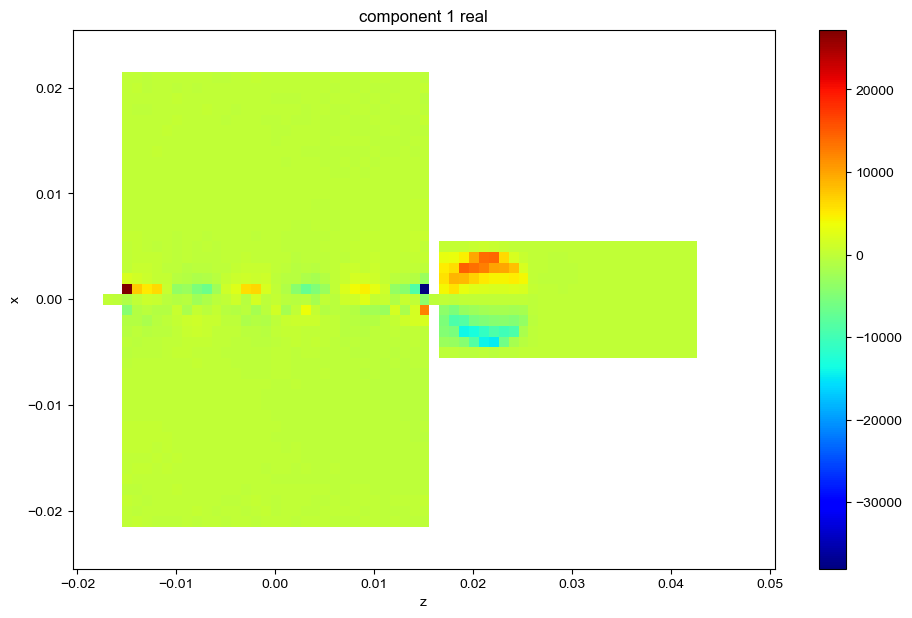

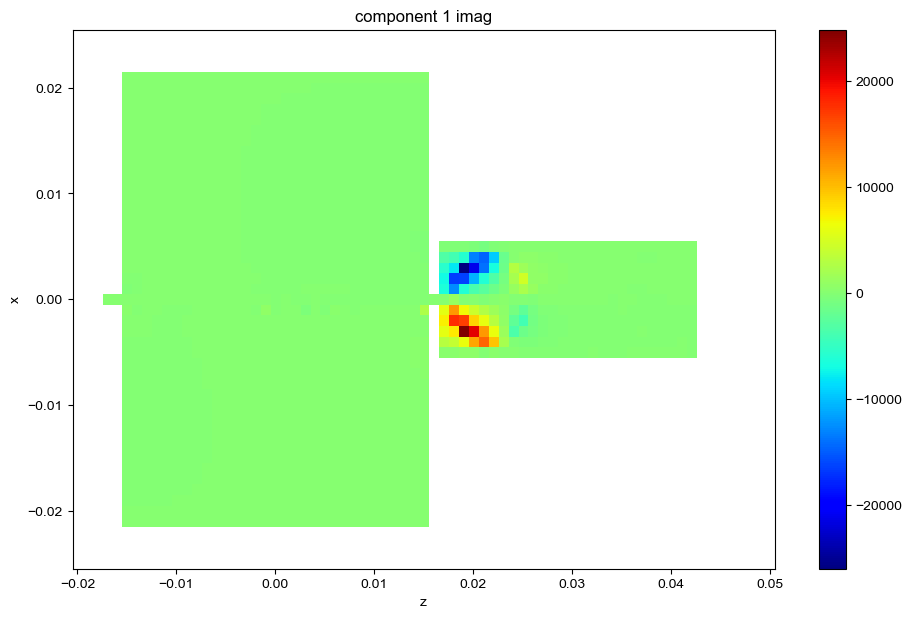

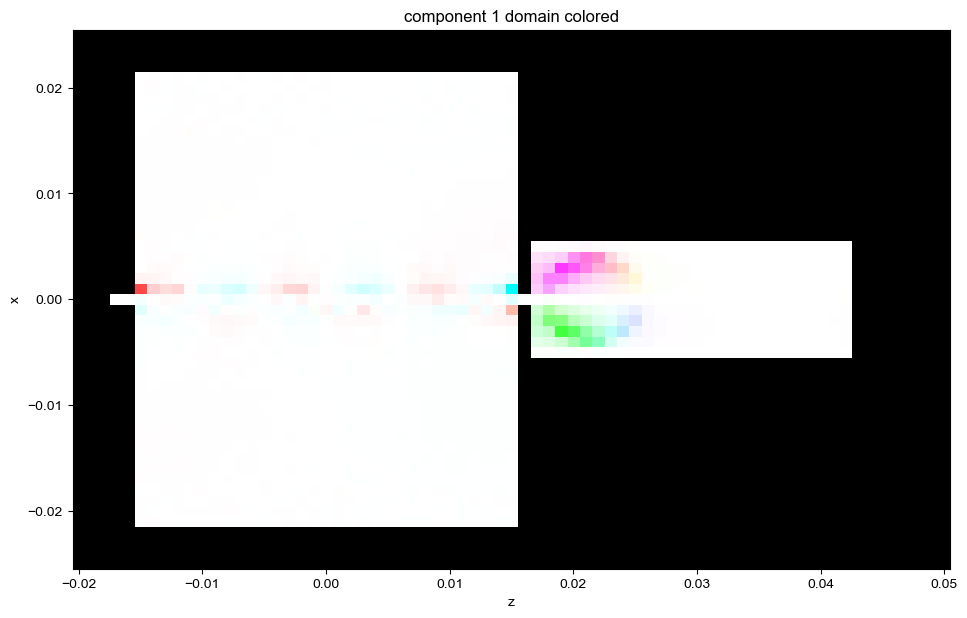

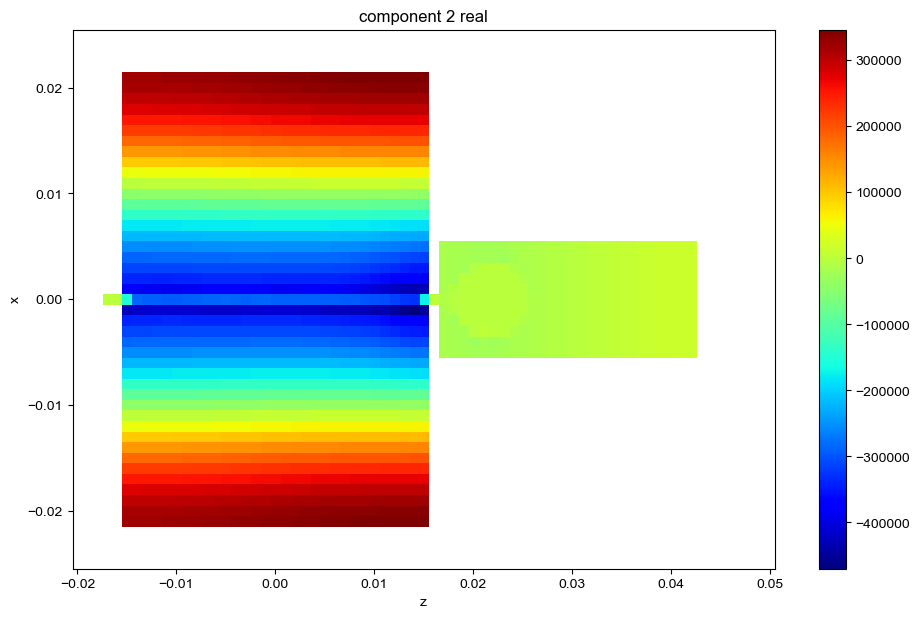

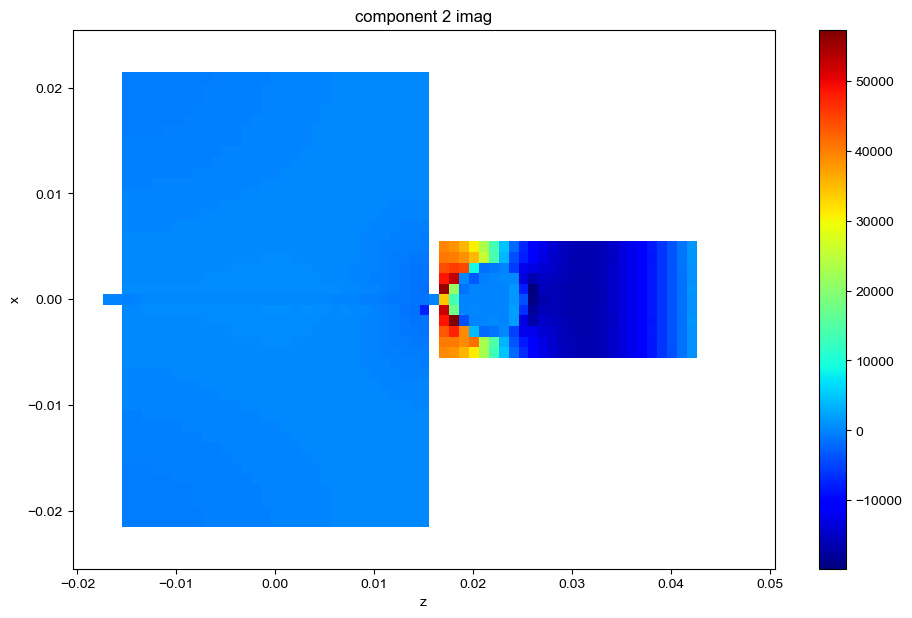

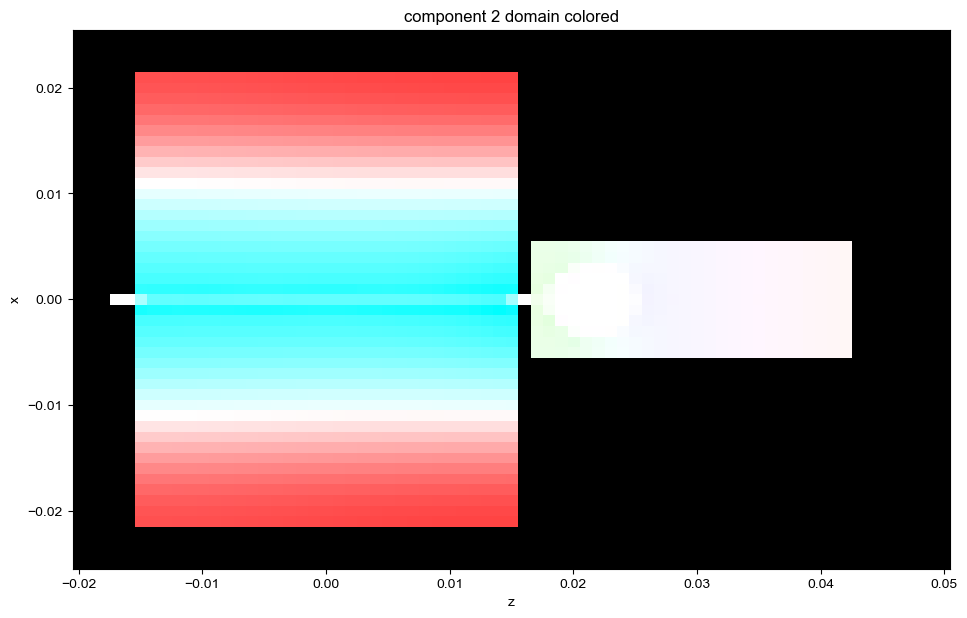

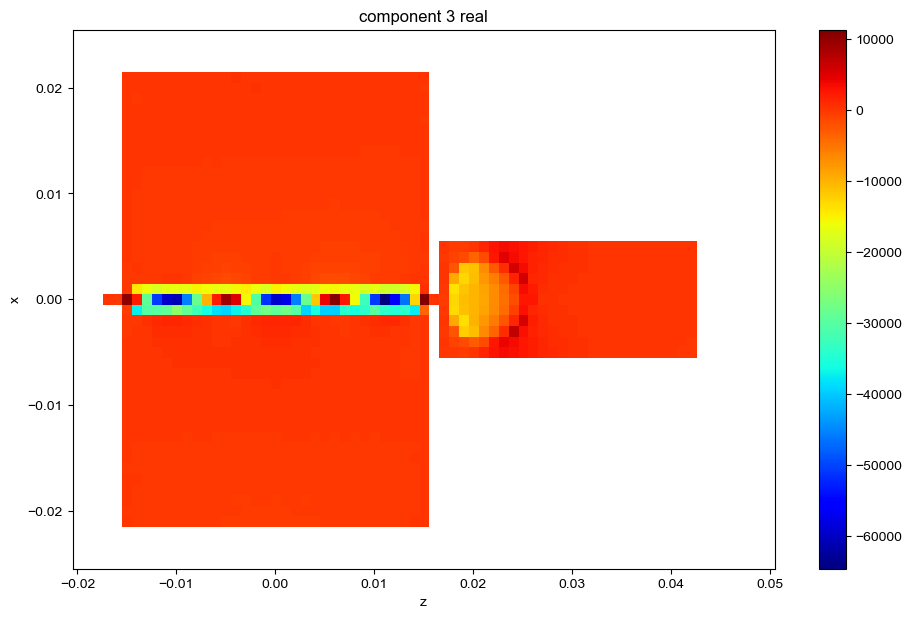

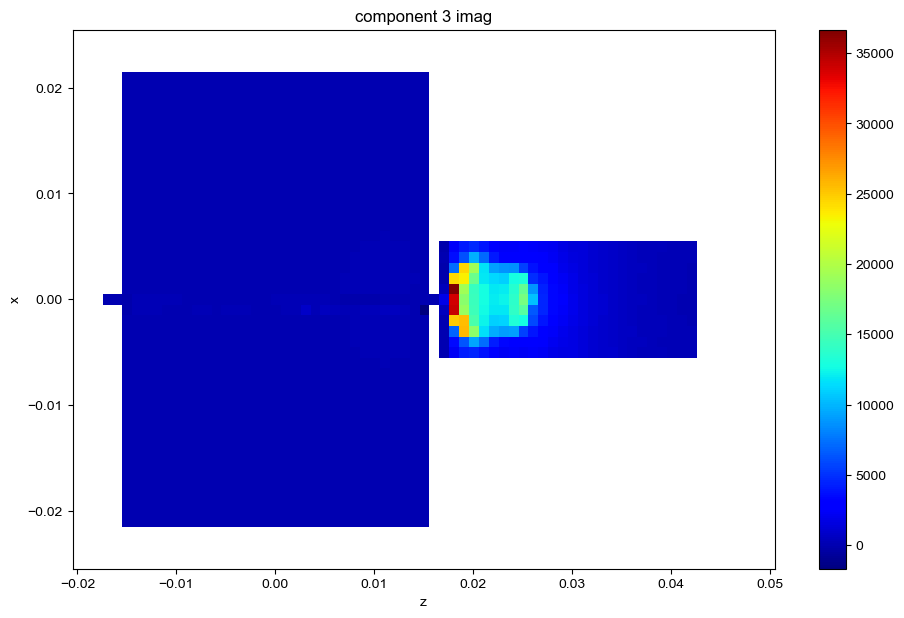

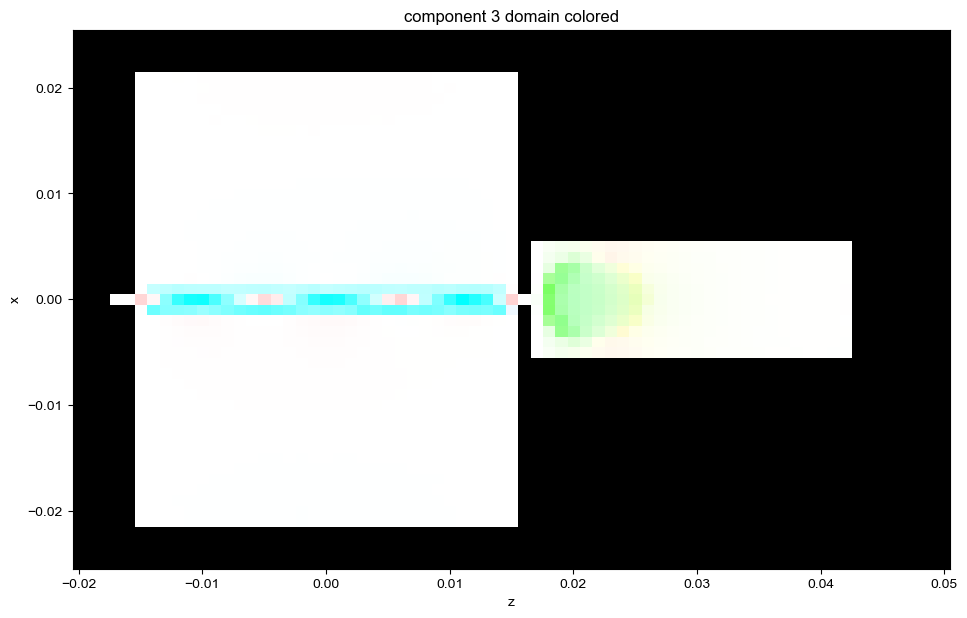

In [17]:
# I could manually set the "extent" kwarg of imshow, but I'm going to load this as an nddata
# to get a plot with coordinates
filename_cmplx_pair = (
    'VectorH_240523.fld', #0 deg phase
    'VectorH_240606_fixed.fld', #90 deg phase
)
def load_hfss_vectors_as_nddata(filename2):
    axis_names = ['x','y','z']
    u_index, u_axis, v_index, v_axis, data2 = load_hfss_vectors(filename2)
    return nddata(data2, data2.shape, [axis_names[u_index], axis_names[v_index], 'vec']).setaxis(
        axis_names[u_index], u_axis).setaxis(axis_names[v_index], v_axis).setaxis('vec',r_[0,1,2])
def load_hfss_complex_vectors(cmplx_pair):
    return ( load_hfss_vectors_as_nddata(cmplx_pair[0])
         + 1j * load_hfss_vectors_as_nddata(cmplx_pair[1]))
d = load_hfss_complex_vectors(filename_cmplx_pair)
d *= 1j # I'm going to flip the phase, since we are interested in imaginary B
for j in range(3):
    figure(j*3+1)
    title(f'component {j+1} real')
    image(d['vec',j].real)
    figure(j*3+2)
    title(f'component {j+1} imag')
    image(d['vec',j].imag)
    figure(j*3+3)
    title(f'component {j+1} domain colored')
    image(d['vec',j])

Test out function, see where there are field values and NAN for first file

In [ ]:
load_hfss_vectors(filename1, show_valid = True)

Use function to show valid field values for file 1

In [ ]:
u_index, u_axis, v_index, v_axis, data1 = load_hfss_vectors(filename1, show_valid = True)
print(shape(data1))

Same as above for file 2

In [ ]:
u_index, u_axis, v_index, v_axis, data2 = load_hfss_vectors(filename2, show_valid = True)
print(shape(data2))

In [ ]:
# first, let's do this with raw matplotlib
for j in range(3):
    figure(j+1)
    data2[:,:,j] = 1j*data2[:,:,j]
    print(shape(data2))
    data_c = data1 + data2
    imshow(data_c[:,:,j])